In [8]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
from scipy.fftpack import fft
import sounddevice as sd
from scipy.signal.windows import hann
from scipy.signal.windows import hamming
from audiolazy import lazy_lpc
import scipy

In [2]:
# provided functions
def est_predictor_gain(x, a, p):
    '''
    A function to compute gain of the residual signal in LP analysis.
    x:  signal 
    a: LPC coefficients
    p: order of the filter
    '''
    cor = np.correlate(x, x, mode='full')
    
    rr = cor[len(cor)//2: len(cor)//2+p+1]
    g = np.sqrt(np.sum(a*rr))
    return g

   
    
def reject_outliers(data, m=2):
    '''
    Function to reject outliers. All values beyond m standard deviations from mean are excluded
    '''
    return data[abs(data - np.mean(data)) < m * np.std(data)]

### 1. Linear prediction analysis. (1 point) 

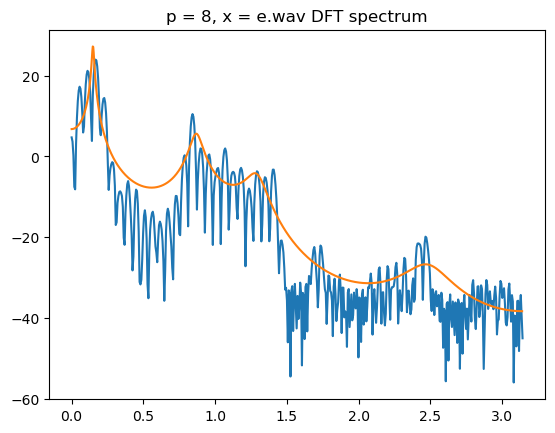

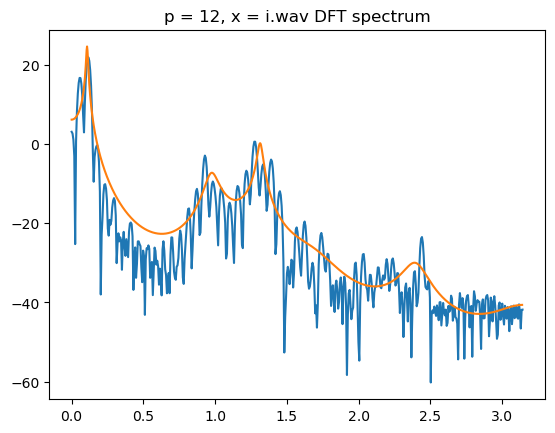

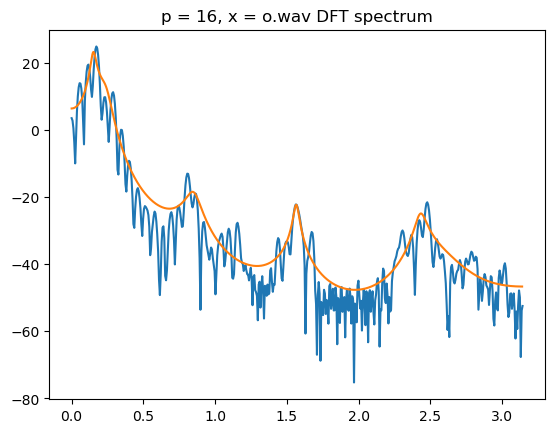

In [ ]:
# Read audio

def analyze_audio_formants(x, p):
    # x = audio signal
    # p = order of the filter

    audioIn, fs = lb.load(x, sr=None)   

    # number of DFT points
    nfft = 1024

    inInd =0
    wLen = int(0.02*fs) # 20 ms window
    win = hamming(wLen) # hamming window for example

    cnt = 0
    numframes = np.ceil( (len(audioIn)-wLen)/(wLen/2)) # number of franes 
    formants  = []                                     # A placeholder for storing formants

    # choose a representative frame of the vowel
    plot_frame = int(numframes/2)  # middle of the vowel

    # The analysis loop
    while inInd< len(audioIn)-wLen:
        # audio frame
        frame = audioIn[inInd:inInd+wLen]* win
        
        
        # a) compute LPC and gain using audiolazy library
        
        lpc_coeffs = lazy_lpc.lpc.autocor(frame, p)
        gain = est_predictor_gain(x=frame, a=lpc_coeffs.numerator, p=p)
        
        # b) Compute the filter tansfer function using scipy.signal.freqz
    
        w, lpc = scipy.signal.freqz(1, lpc_coeffs.numerator, worN=nfft)
        # normalize lpc
        lpc = lpc*gain
        
        # Compute DFT spectrum
        # DFT of the frame
        dft = fft(frame, n=nfft)
        dft = dft[:nfft//2]
        w_dft = np.linspace(0, np.pi, nfft//2)

        inInd = inInd + int(wLen/2) # frame advance
        
        cnt = cnt+1
            
        # c) Select a frame and plot the FFT spectrum and LPC spectrum in the same figure
        if cnt == plot_frame :
            # plot DFT spectrum (remember both in dB scale)
            plt.figure()
            plt.plot(w_dft, 20 * np.log10(abs(dft)))
            plt.title(f'p = {p}, x = {x} DFT spectrum')
            # plot LPC spectrum
            plt.plot(w, 20 * np.log10(abs(lpc)))
            plt.show()
        
analyze_audio_formants('e.wav', 8)
analyze_audio_formants('i.wav', 12)
analyze_audio_formants('o.wav', 16)
        

#### d) Comment of the connection between lpc model order and peaks in the DFT spectrum.

The model order represents the polynomial order of the lpc model, so the accuracy (how well it matches with the signal) increases as the order is increased.

#### Is the best order selection dependent on the vowel or not?

Yes, it does. The more complex the vowel waveform, the bigger the order needed to represent the envelope.

### 2. Formant analysis. (1 point)

#### Add more steps in the previous analysis loop

In [68]:
# Read audio

def analyze_audio_formants(x, p):
    # x = audio signal
    # p = order of the filter

    audioIn, fs = lb.load(x, sr=None)   

    # number of DFT points
    nfft = 1024

    inInd =0
    wLen = int(0.02*fs) # 20 ms window
    win = hamming(wLen) # hamming window for example

    cnt = 0
    numframes = np.ceil( (len(audioIn)-wLen)/(wLen/2)) # number of franes 
    formants  = []                                     # A placeholder for storing formants

    # choose a representative frame of the vowel
    plot_frame = int(numframes/2)  # middle of the vowel

    # The analysis loop
    while inInd< len(audioIn)-wLen:
        # audio frame
        frame = audioIn[inInd:inInd+wLen]* win
        
        
        # a) compute LPC and gain using audiolazy library
        
        lpc_coeffs = lazy_lpc.lpc.autocor(frame, p)
        gain = est_predictor_gain(x=frame, a=lpc_coeffs.numerator, p=p)
        
        # b) Compute the filter tansfer function using scipy.signal.freqz
    
        w, lpc = scipy.signal.freqz(1, lpc_coeffs.numerator, worN=nfft)
        # normalize lpc
        lpc = lpc*gain
        
        # Compute DFT spectrum
        # DFT of the frame
        dft = fft(frame, n=nfft)
        dft = dft[:nfft//2]
        w_dft = np.linspace(0, np.pi, nfft//2)

        inInd = inInd + int(wLen/2) # frame advance
        
        cnt = cnt+1
        
        # a) Compute roots (np.roots)

        roots = np.roots(lpc_coeffs.numerator)   
 
        # LPC coefficients are real-valued, the roots occur in complex conjugate pairs.
        # Retain only the roots with +ve sign for the imaginary part

        roots = roots[np.imag(roots) > 0] 
    
        # b.1) compute formants from roots (np.angle)
        angz = np.angle(roots)

        # convert to Hertz from angular frequencies
        angz = angz*(fs/(2*np.pi))

        # sort the formants in increasing order
        angz = np.sort(angz)
        
        # remove zero frequencies
        angz = angz[angz !=0] 

        # c) Select a frame and plot the FFT spectrum and LPC spectrum in the same figure
        """ if cnt == plot_frame :
            # plot DFT spectrum (remember both in dB scale)
            plt.figure()
            plt.plot(w_dft, 20 * np.log10(abs(dft)))
            plt.title(f'p = {p}, x = {x} DFT spectrum')
            # plot LPC spectrum
            plt.plot(w, 20 * np.log10(abs(lpc)))
            plt.show() """

    # b.2) Save first three formants
    formants.append(angz[:3])
    print(f'{x}------ The computed formants are :, {np.mean(formants, 0)}')
        
analyze_audio_formants('e.wav', 18)
analyze_audio_formants('i.wav', 13)
analyze_audio_formants('o.wav', 20)


e.wav------ The computed formants are :, [ 415.38955193 2145.76727762 2840.53386472]
i.wav------ The computed formants are :, [ 238.71532008 2095.07977947 3209.59005316]
o.wav------ The computed formants are :, [ 440.76180266  949.68533887 1991.01115037]


#### b.4) Compare the obtained values with the indicative values. 

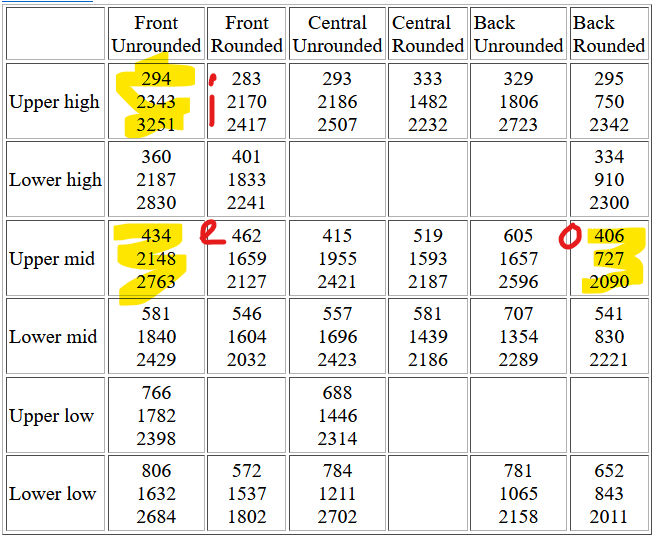

The indicative and obtained values are close, but not identical. The error seems to be about 50-200 Hz.

### Bonus problem: What happens if you apply LPC to the oboe sound? What are the corresponding "formants"?